# AutoCallibration with SDO data

Bring in SDO data to our autocallibration brightness regression network.

Note that this notebook should be run from the `notebooks/` subdirectory.

In [12]:
# NOTE: Change this to what the notebook name is for each experiment to ensure
# training results are saved into the right sub-directory.
notebook_name = '02b_autocallibration_sdo'

from collections import namedtuple, defaultdict
import logging
import math
import random
import os
import shutil
import sys
import pdb
from functools import reduce
import operator

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import pandas

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

# Make sure ~/expanding-sdo-capabilities/src is in your PYTHONPATH
from sdo.sdo_dataset import SDO_Dataset

In [13]:
# Set up nice logging for the SDO package.
# TODO: Set up fancy logging for the rest of this notebook as well.
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

In [14]:
# Path to data and training results.
root_path = '..' # Relative to root directory of expanding-sdo-capabilities git repo.
results_path = os.path.join(root_path, 'training_results', notebook_name)
model_path = os.path.join(results_path, 'model.pth')
optimizer_path = os.path.join(results_path, 'optimizer.pth')

for path in [results_path]:
  if not os.path.exists(path):
    print('{} does not exist; creating directory...'.format(os.path.abspath(path)))
    os.makedirs(path)

# AIA wavelengths to each have as a channel going into the deep net.
wavelengths = ['0094',
               '0131',
               '0171',
               '0193',
               '0211',
               '0304',
               '0335']
    
num_epochs = 5
batch_size_train = 10
batch_size_test = 10
log_interval = 10
height = 128
width = 128
num_channels = len(wavelengths)
instruments = ['AIA'] * num_channels
subsample = 4 # Downsample from 512 / 4 = 128

In [15]:
def init_gpu(cuda_device=0):
  """ Use the GPU. """
  torch.backends.cudnn.enabled = True
  if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available! Unable to continue")
  # Force ourselves to use only one GPU.
  device = torch.device("cuda:{}".format(cuda_device))
  print("Using device {} for training, current device: {}, total devices: {}".format(
    device, torch.cuda.current_device(), torch.cuda.device_count()))
  return device

def set_seed(random_seed=1, deterministic_cuda=True):
  """ Force runs to be deterministic and reproducible. """
  np.random.seed(random_seed)
  random.seed(random_seed)
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  os.environ['PYTHONHASHSEED'] = str(random_seed)

  # Note: this can have a performance hit.
  if deterministic_cuda:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
device = init_gpu(cuda_device=1)
set_seed()

Using device cuda:1 for training, current device: 0, total devices: 6


In [17]:
class Net(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        if (len(input_shape) != 3):
            raise ValueError('Expecting an input_shape representing dimensions CxHxW')
        self._input_channels = input_shape[0]
        print('input_channels: {}'.format(self._input_channels))
        self._conv2d1 = nn.Conv2d(in_channels=self._input_channels, out_channels=64, kernel_size=3)
        self._conv2d2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self._cnn_output_dim = self._cnn(torch.zeros(input_shape).unsqueeze(0)).nelement()
        print('cnn_output_dim: {}'.format(self._cnn_output_dim))
        self._fc1 = nn.Linear(self._cnn_output_dim, 256)
        self._fc2 = nn.Linear(256, output_dim)
        
    def _cnn(self, x):
        x = self._conv2d1(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        x = self._conv2d2(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        return x
    
    def forward(self, x):
        batch_dim = x.shape[0]
        x = self._cnn(x).view(batch_dim, -1)
        x = self._fc1(x)
        x = torch.relu(x)
        x = self._fc2(x)
        x = torch.sigmoid(x)
        return x

In [18]:
class DimmedSDO_Dataset(SDO_Dataset):
  def __init__(self, num_channels, *args, **kwargs):
    super(DimmedSDO_Dataset, self).__init__(*args, **kwargs)
    self._num_channels = num_channels
    
    # TODO: Compute mean and std across dataset, and normalize them.
    
  def __getitem__(self, idx):
    imgs = super(DimmedSDO_Dataset, self).__getitem__(idx)    
    # Scale the image to between [0.0, 1.0]
    # Note: if we don't do this scaling, training and testing don't work!
    imgs = imgs / imgs.max()
    dimmed_imgs = imgs.clone().to(device)
    dim_factor = torch.rand(self._num_channels).to(device)    
    for c in range(self._num_channels):
      dimmed_imgs[c] *= dim_factor[c]
      
    return dimmed_imgs, dim_factor, imgs

In [19]:
# Note: we are _not_ doing normalization (centering and whitening) currently.
train_dataset = DimmedSDO_Dataset(num_channels, device, instr=instruments, channels=wavelengths,
                                  yr_range=[2012, 2013], subsample=subsample,
                                  normalization=0, bytescaling=False)
test_dataset = DimmedSDO_Dataset(num_channels, device, instr=instruments, channels=wavelengths,
                                 yr_range=[2012, 2013], subsample=subsample,
                                 normalization=0, bytescaling=False, test=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size_train,
                          shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test,
                         shuffle=True)

[2019-07-19 00:14:02] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-19 00:14:02] INFO:sdo.sdo_dataset:Running on months "[1 2 3 4 5 6 7 8]"
[2019-07-19 00:14:02] INFO:sdo.sdo_dataset:Number of SDO files = 915
[2019-07-19 00:14:02] INFO:sdo.sdo_dataset:Loading SDOML from "/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/SDOML"
[2019-07-19 00:14:02] INFO:sdo.sdo_dataset:Running on months "[10 11 12]"
[2019-07-19 00:14:02] INFO:sdo.sdo_dataset:Number of SDO files = 121


In [20]:
def show_sample_image(loader):
  print('\nUndimmed channels for single time slice:\n')
  _, _, item = loader.dataset[0]
  print('Max value: {}, min value: {}'.format(torch.max(item), torch.min(item)))
  print('Shape: {}'.format(item.shape))
  print('Dtype: {}'.format(item.dtype))
  fig, ax = plt.subplots(1, num_channels, figsize=(10,10), sharey=True)
  for c in range(num_channels):
    ax[c].title.set_text('Channel {}'.format(c + 1))
    ax[c].imshow(item[c].cpu().numpy(), cmap='gray')

def print_details(orig_data, output, dimmed_data, dim_factors, train):
  print('\n\nDetails with sample from final batch:')
  data_min, data_max = torch.min(orig_data), torch.max(orig_data)
  sample = orig_data[0].cpu().numpy()
  sample_dimmed = dimmed_data[0].cpu().numpy()

  for i, (channel, channel_dimmed) in enumerate(zip(sample, sample_dimmed)):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(channel, norm=None, cmap='hot', vmin=data_min, vmax=data_max)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(channel_dimmed, norm=None, cmap='hot', vmin=data_min, vmax=data_max)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(channel_dimmed / float(output[0, i]), norm=None, cmap='hot', vmin=data_min, vmax=data_max)
    print('\nChannel: {} (left: original, middle: dimmed, right: undimmed)\nDimming (true): {}, dimming (predicted): {}'.format(
      i, dim_factors[0, i], output[0, i]))
    plt.show()
  dim_factors_numpy = dim_factors[0].view(-1).cpu().numpy()
  plt.plot(dim_factors_numpy, label='Dimming factors (true)')
  output_numpy = output[0].detach().view(-1).cpu().numpy()
  plt.plot(output_numpy, label='Dimming factors (predicted)')
  title = 'training dimming factors' if train else 'testing dimming factors'
  plt.title(title)
  plt.legend()
  plt.show()

def generate_train_accuracy_stats(correct, output, targets, num_column_labels, num_subsample):
  # TODO: For efficiency reasons, convert all of this to torch rather than numpy operations
  # so that we can do all this work on the GPU.
  preds = output.detach().cpu().numpy()
  targets = targets.detach().cpu().numpy()

  # If a channel brightness prediction is within this percentage of the ground truth then we
  # consider that prediction correct.
  pct_close = 0.15

  # Means across each row that collapses each batch entries predictions,
  # the ground truth brightness, and the delta btw ground truth and prediction.
  mean_per_channel_prediction = preds.mean(axis=0)
  mean_per_channel_gt = targets.mean(axis=0)
  per_channel_diff = np.abs(targets - preds)
  mean_per_channel_diff = per_channel_diff.mean(axis=0)

  # Various stats around channel correctness.
  per_channel_correct = per_channel_diff <= np.abs(pct_close * targets)
  # TODO: We can probably get rid of both of these np.where() conversions to 1/0s and just use the boolean
  # array itself for the sum.
  percentage_channels_correct = np.sum(np.where(per_channel_correct, 1, 0), axis=1, keepdims=True,
                                       dtype=np.int)
  correct_per_channel = np.sum(np.where(per_channel_correct, 1, 0), axis=1, keepdims=True,
                               dtype=np.int)
  pct_correct_per_channel = correct_per_channel / num_channels

  # Which batch results have _all_ of their channel predictions fully correct?
  # TODO: We can probably get rid of the np.where() conversion to 1/0s and just use the boolean
  # array itself for the sum.
  num_fully_correct_all_channels = np.where(pct_correct_per_channel == 1.0, 1, 0).sum()
  pct_fully_correct_all_channels = num_fully_correct_all_channels / batch_size_test
  correct += num_fully_correct_all_channels
  
  pretty_results = np.zeros((min(batch_size_test, len(preds)), num_column_labels), dtype=np.float32)

  # The mean channel prediction across each row of the batch results.
  pretty_results[:, 0] = np.round(preds.mean(axis=1), decimals=2)

  # The mean channel ground truth across each row of the batch results.
  pretty_results[:, 1] = np.round(targets.mean(axis=1), decimals=2)

  # The mean difference btw prediction and grouth truth across each row of the batch results.
  pretty_results[:, 2] = np.round(np.abs(targets - preds).mean(axis=1), decimals=2)

  # Percentage correct across all the channels for a given batch row?
  pretty_results[:, 3] = np.round(pct_correct_per_channel * 100.0, decimals=0)[:, 0].astype(np.int)
  
  # Randomly sub-sample some of the results since 100s or 1000s are too much to display.
  lookup_idxs = np.random.choice(len(pretty_results), size=(num_subsample,))
  pretty_results = pretty_results[lookup_idxs]

  return correct, pretty_results


Undimmed channels for single time slice:

Max value: 1.0, min value: 0.0
Shape: torch.Size([7, 128, 128])
Dtype: torch.float32
input_channels: 7
cnn_output_dim: 21632


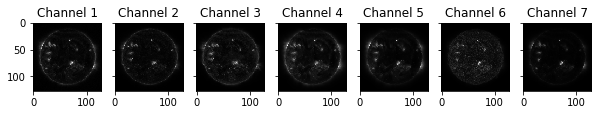

In [21]:
show_sample_image(train_loader)

model = Net(input_shape=[num_channels, height, width], output_dim=num_channels)
model.cuda(device)
optimizer = torch.optim.Adam(model.parameters())

# TODO: Training is slow; figure out why.
def train(epoch):
  print("\n\n===================================\n\n")
  print("\n\nTraining epoch {}\n".format(epoch))
  model.train()
  losses = []
  for batch_idx, (dimmed_data, dim_factors, orig_data) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(dimmed_data)
    loss = nn.MSELoss()(output, dim_factors)
    loss.backward()
    optimizer.step()
    losses.append(float(loss))

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(orig_data), len(train_loader.dataset),
        100.0 * (batch_idx / len(train_loader)), float(loss)))
      # TODO: Save the model.
      # torch.save(model.state_dict(), model_path)
      # torch.save(optimizer.state_dict(), optimizer_path)

  # Print extra debug output on the final batch.
  print_details(orig_data, output, dimmed_data, dim_factors, train=True)

  plt.plot(losses, label='training loss')
  plt.title('training loss')
  plt.show()
  
  print('\nAt end of train epoch {}, loss min: {}, max: {}, mean: {}'.format(epoch,
    min(losses), max(losses), np.mean(losses)))
  
  return np.mean(losses)

def test(epoch):
  print("\n\nTesting epoch {}".format(epoch))
  with torch.no_grad():
    model.eval()
    losses = []
    correct = 0
    current_batch = 0
    num_subsample = 3 # Per batch, how many results to subsample to print out for debugging.
    column_labels = ['Pred', 'GT', 'Delta', 'Pct Correct']
    pretty_results = np.zeros((int(math.ceil(len(test_loader.dataset) / batch_size_test) * num_subsample),
                               len(column_labels)), dtype=np.float32)
    for batch_idx, (dimmed_data, dim_factors, orig_data) in enumerate(test_loader):
      current_batch += 1
      dimmed_data = dimmed_data.to(device)
      dim_factors = dim_factors.to(device)
      output = model(dimmed_data)
      output = output.to(device)
      loss = nn.MSELoss()(output, dim_factors)
      losses.append(float(loss))

      correct, pretty_print_subset = generate_train_accuracy_stats(
        correct, output, dim_factors, len(column_labels), num_subsample)
      current_batch_idx = current_batch - 1
      pretty_results[current_batch_idx*num_subsample:current_batch_idx*num_subsample+num_subsample] = pretty_print_subset

    # Print extra debug output on the final batch.
    print_details(orig_data, output, dimmed_data, dim_factors, train=False)
    
    print("\n\nRandom sample of mean predictions across channels for test set, "
          "where each row is a test sample in the training batch:\n")
    df = pandas.DataFrame(pretty_results, columns=column_labels)
    print(df.to_string(index=False))
    
    # TODO: Create a testing accuracy chart over all epochs to see progression.
    
    print('\n\nEpoch {}, test set: avg. loss: {:.8f}, Accuracy all channels correct: {}/{} ({:.0f}%)'.format(
          epoch, np.mean(losses), correct, len(test_loader.dataset),
          100.0 * (correct / len(test_loader.dataset))))

    return np.mean(losses)







Training epoch 1

Train Epoch: 1 [0/915 (0%)]	Loss: 0.075755
Train Epoch: 1 [100/915 (11%)]	Loss: 0.069078
Train Epoch: 1 [200/915 (22%)]	Loss: 0.077796
Train Epoch: 1 [300/915 (33%)]	Loss: 0.067748
Train Epoch: 1 [400/915 (43%)]	Loss: 0.054700
Train Epoch: 1 [500/915 (54%)]	Loss: 0.086944
Train Epoch: 1 [600/915 (65%)]	Loss: 0.045911
Train Epoch: 1 [700/915 (76%)]	Loss: 0.060493
Train Epoch: 1 [800/915 (87%)]	Loss: 0.051959
Train Epoch: 1 [900/915 (98%)]	Loss: 0.062024


Details with sample from final batch:

Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.15250003337860107, dimming (predicted): 0.42562657594680786


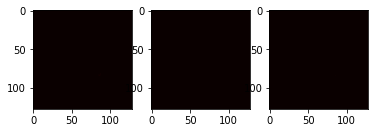


Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4712311625480652, dimming (predicted): 0.3122597932815552


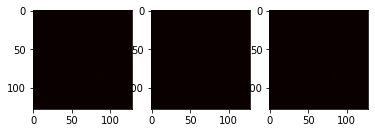


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9705836772918701, dimming (predicted): 0.28742727637290955


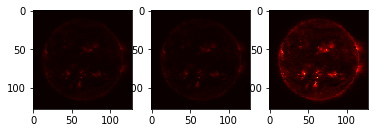


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2860613465309143, dimming (predicted): 0.06823423504829407


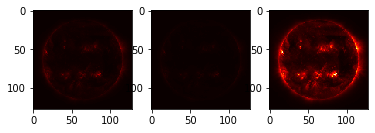


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6053946614265442, dimming (predicted): 0.21528710424900055


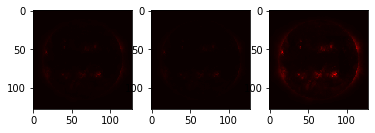


Channel: 5 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.16914069652557373, dimming (predicted): 0.3042806386947632


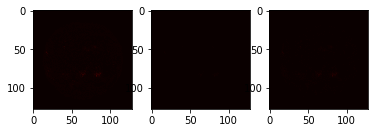


Channel: 6 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5602879524230957, dimming (predicted): 0.5140460729598999


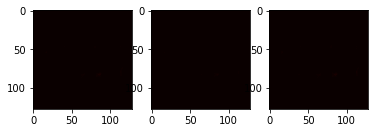

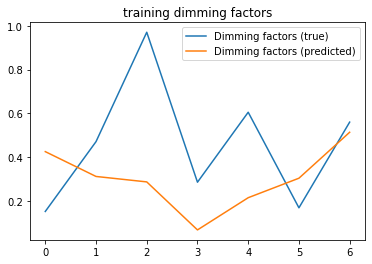

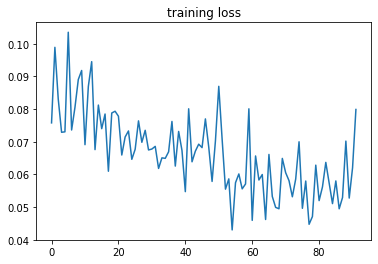


At end of train epoch 1, loss min: 0.04298565536737442, max: 0.10350358486175537, mean: 0.06655835461519334


Testing epoch 1


In [ ]:
train_losses = []
test_losses = []
for epoch in range(1, num_epochs + 1):
  train_losses.append(train(epoch))
  test_losses.append(test(epoch))
  
  plt.plot(test_losses, label='testing loss')
  plt.title('testing loss after {} epochs'.format(epoch))
  plt.show()
  
print('\n\nFinal mean training loss after {} epochs: {}'.format(
  num_epochs, np.mean(train_losses)))
print('Final mean testing loss after {} epochs: {}'.format(
  num_epochs, np.mean(test_losses)))